In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
Transform = transform.Compose([transform.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist/',train=True,download=True,transform=Transform)
aux = torch.tensor(np.random.randint(0, 10, len(trainset)))
trainset.targets = aux

testset = torchvision.datasets.MNIST(root='./data_mnist/',train=False,download=True,transform=Transform)

trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
testloader = DataLoader(testset,batch_size=64,shuffle=True)

In [4]:
class my_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv2 = nn.Conv2d(10,16,3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(16*5*5,512)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(512,256)
        self.act4 = nn.ReLU()
        
        self.fc5 = nn.Linear(256,125)
        self.act5 = nn.ReLU()
        
        self.fc6 = nn.Linear(125,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flat(x)
        
        x = self.act3(self.fc3(x))
        x = self.act4(self.fc4(x))
        x = self.act5(self.fc5(x))
        x = self.fc6(x)
        return x
    
def Train_(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_train = 0
    for input, label in trainloader:
        input, label = input.to(device), label.to(device)
        y_hat = model(input).to(device)
        loss = model.cross_ent(y_hat,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.cpu().data.numpy().item()
    loss_train = loss_train*100/len(trainloader.dataset)
    return model, loss_train

def Test_(model):
    model.eval()
    loss_test = 0
    for input, label in testloader:
        input, label = input.to(device), label.to(device)
        y_hat = model(input).to(device)
        loss = model.cross_ent(y_hat,label)
        loss_test += loss.cpu().data.numpy().item()
    loss_test = loss_test*100/len(testloader.dataset)
    return loss_test

100%|██████████| 50/50 [08:23<00:00, 10.08s/it]


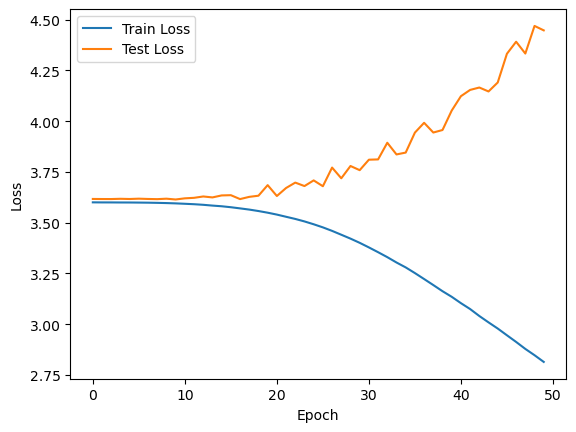

In [5]:
if __name__=='__main__':
    Epoch = 50
    model = my_cnn().to(device)
    loss_train=[]; loss_test=[]
    for ep in tqdm(range(Epoch)):
        model, lt = Train_(model)
        loss_train.append(lt)
        loss_test.append(Test_(model))
    plt.plot(loss_train,label='Train Loss')
    plt.plot(loss_test,label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()